In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

#import pyphysio
import pyphysio as ph
import pandas as pd
import pyphysio.filters.Filters as flt

# (should) show plots in a separate window
%matplotlib inline

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [2]:
# open file
df_EDA = pd.read_csv('EDA_pp37.csv', header=None)

# create the signal
fsamp = 4 #Hz
tstart_df_EDA = 0 #s


eda = ph.EvenlySignal(values = df_EDA.values.ravel(), 
                      sampling_freq = fsamp,
                      start_time = tstart_df_EDA)

In [3]:
#count n of rows to get time of recording (s) 
n_of_rows = df_EDA.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/4
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

# save data 
outputFile=open("time_pp37.txt", 'a')
outputFile.write("{}\n{}\n".format(walk_time_seconds, walk_time_minutes))
outputFile.close()


0    13980
dtype: int64
0    3495.0
dtype: float64
0    58.25
dtype: float64


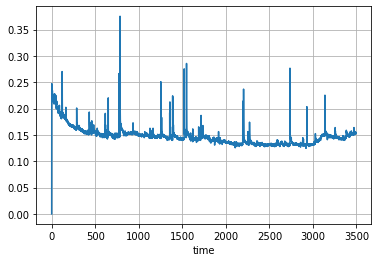

In [4]:
# plot
plot = eda.plot()
# plt.show() #using matplotlib to show the plot

In [5]:
#signal is quite noisy (moving artifacts)
#consider the possibility of filtering it

#e.g. simple moving average filter
mov_avg = flt.ConvolutionalFilter('rect', win_len = 1)
eda = mov_avg(eda)

#however, check that you are not losing information


In [6]:
#create baseline (10mins) / label variable
#[0s-600s] #baseline 
#[600s -3480s] #actual recording session 

label = np.zeros(3495) #s
label[0:600] = 1
label[600:3495] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label')

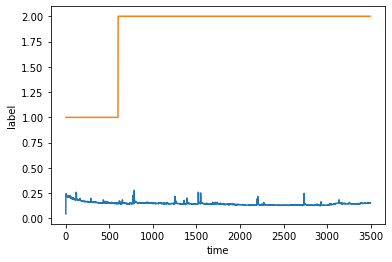

In [7]:
#see also the plots
eda.plot()
label.plot()

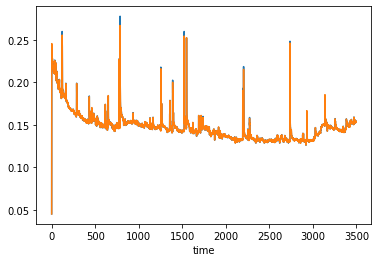

In [8]:
## filtering 
eda_filt = ph.IIRFilter(fp=0.8, fs=1.1, ftype='ellip')(eda)

eda.plot()
eda_filt.plot()

In [9]:
eda = eda_filt

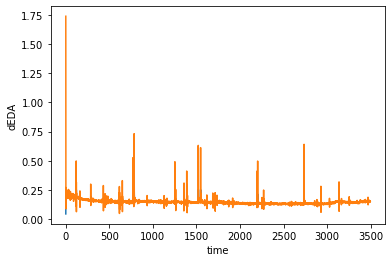

In [10]:
## estimate the driver function 
driver = ph.DriverEstim(t1=.75, t2=2)(eda)
eda.plot()
driver.plot()

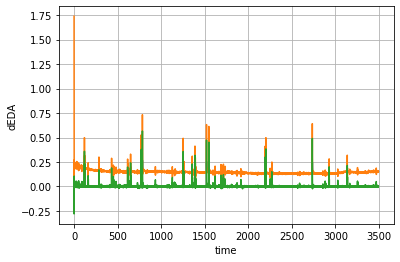

In [11]:
## compute tonic and phasic components
phasic, tonic, tmp_ = ph.PhasicEstim(delta=0.02)(driver)
eda.plot()
driver.plot()
phasic.plot()

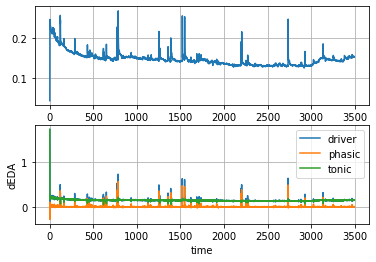

In [12]:
# check results so far
plt.figure() 
ax1 = plt.subplot(211)
eda.plot()
plt.subplot(212, sharex = ax1)
driver.plot()
phasic.plot()
tonic.plot()
plt.legend(['driver', 'phasic', 'tonic'])
plt.show()

In [13]:
## define a list of indicators
indicators_eda = [ph.Mean(name='PhaMean'),
                  ph.StDev(name='StDev'),
                  ph.AUC(name='AUC'),
                  ph.PeaksMean(name='PeaksMean', delta=0.02), 
                  ph.DurationMean(name='DurMean', delta=0.02)]

In [14]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)              
                  
## compute indicators of phasic signal
pha_ind, col_names = ph.fmap(fixed_length, indicators_eda, phasic) 

In [15]:
#save results into a dataframe
phasic_indicators = pd.DataFrame(pha_ind, columns=col_names)

In [16]:
phasic_indicators.head()

,begin,end,label,PhaMean,StDev,AUC,PeaksMean,DurMean
0,0.0,60.0,1.0,0.003149,0.035613,0.188941,0.039932,1.431818
1,60.0,120.0,1.0,0.008273,0.037006,0.496367,0.088205,1.416667
2,120.0,180.0,1.0,0.010297,0.031718,0.617820,0.135344,1.300000
3,180.0,240.0,1.0,0.000062,0.002433,0.003690,NaN,NaN
4,240.0,300.0,1.0,0.003071,0.019891,0.184286,0.169566,1.500000


In [17]:
phasic_indicators.to_csv('phasicindicators_pp37.csv')

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


{'whiskers': [<matplotlib.lines.Line2D at 0x1c25fb6910>,
 'caps': [<matplotlib.lines.Line2D at 0x1c25fbbd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c25fb68d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1c25fc4810>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c25fc4d10>,
 'means': []}

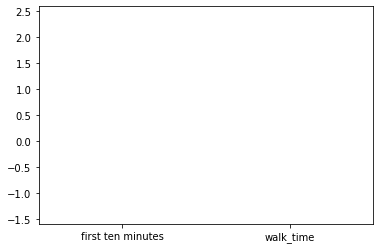

In [18]:
## Box-Whisker plot
# extract column with the labels for each window
label_w = pha_ind[:, np.where(col_names == 'label')[0]]

# extract column with PksMean values
# computed from each window
pksmean_w = pha_ind[:, np.where(col_names == 'PeaksMean')[0]]

pksmean_baseline = pksmean_w[np.where(label_w==1)[0]]
pksmean_walk_time = pksmean_w[np.where(label_w==2)[0]]

## create a boxplot and a whisker plot
## compare the distribution of the RRmean indicator
plt.boxplot([pksmean_baseline, pksmean_walk_time],
              labels=['first ten minutes', 'walk_time'])

##plt.show()